This notebook, based on [Online Retail II UCI](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci) dataset, is all about sales analytics. Here, I will use Python and its libs to do the following:
- investigate the dataset and clean the data;
- find most and least expensive products;
- have a deeper look at sales numbers, using different dimensions - countries, products, customers;
- perform cohort analysis for retention rate and for average sales quantity;
- take a look at how sales amount was changing with time.
- Perform Kmeans Clusterring on the data based on purchasing pattern of the customers.

## Importing Important Libraries

In [51]:
import numpy as np 
import pandas as pd 
import datetime as dt 
import plotly.express as px 
import plotly.graph_objects as go 
from sklearn.preprocessing import StandardScaler
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,accuracy_score
import operator
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA

## Reading the dataset

In [52]:
retail = pd.read_excel('online_retail_II.xlsx')

## Checking and Preparing the Data

In [53]:
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [54]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


**First observations:**
- 'InvoiceDate' column contains datetime information, while having type 'object' - therefore conversion will be required to perform datetime operations. I will use a separate column 'InvoiceDate_DT' for this;
- Most columns have 1067371 rows. Exceptions are columns 'Description' with 1062989 rows and 'Customer ID' with 824364 rows. Some data is missing there. I will hardly use 'Description' during my analysis, but 'Customer ID' is a must for my analysis, so I will drop the rows with missing customer IDs;
- 'Customer ID' column has type 'float64', while 'int64' would be absolutely sufficient - again, type conversion will be a good idea here in order to operate the data properly.
- While we have columns for product price and quantity, it will be very helpful to get also total value of each transaction - I will calculate it in a separate column.
- Finally, I will sort my data chronologically.

### Cleaning and Preprocessing the data

In [55]:
retail['InvoiceDate_DT'] = pd.to_datetime(retail['InvoiceDate'])
retail = retail[retail['Customer ID'].notna()]
retail['Customer ID'] = retail['Customer ID'].astype(np.int64)
retail = retail.sort_values('InvoiceDate_DT')
retail['Total'] = retail['Quantity'] * retail['Price']

## General Sales Analytics
### Most and Least Expensive Product

In [56]:
most_expensive = retail.loc[retail['Price'] == retail['Price'].max()]
most_expensive 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceDate_DT,Total
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399,United Kingdom,2010-06-17 16:52:00,-25111.09


In [57]:
least_expensive = retail.loc[retail['Price'] == retail['Price'].min()]
least_expensive = least_expensive.groupby(['Description', 'Price'], as_index=False)['Quantity'].agg('sum')
least_expensive 

,Description,Price,Quantity
0,FLAMINGO LIGHTS,0.0,24
1,6 RIBBONS EMPIRE,0.0,12
2,AIRLINE BAG VINTAGE JET SET WHITE,0.0,1
3,ANTIQUE GLASS HEART DECORATION,0.0,12
4,ANTIQUE LILY FAIRY LIGHTS,0.0,8
5,BREAD BIN DINER STYLE RED,0.0,1
6,CAKE STAND LACE WHITE,0.0,2
7,CAST IRON HOOK GARDEN FORK,0.0,8
8,CAST IRON HOOK GARDEN TROWEL,0.0,8
9,"CHARLOTTE BAG , SUKI DESIGN",0.0,10


We can see that the most expensive product in the dataset has a weird description 'Manual' and is priced at **£38970.0**. It is interesting that the quantity is -1; looks like someone returned an item priced that high or did not pay for it yet.

Finding the least expensive product needs one extra step, because we have 61 unique descriptions of products priced at £0.0. Now, what if we disregard zero-priced products in order to get more meaningful insights?

In [58]:
retail_non_zero_price = retail.loc[retail['Price'] != 0]
least_expensive_not_null = retail_non_zero_price.loc[retail_non_zero_price['Price'] == retail_non_zero_price['Price'].min()]
least_expensive_not_null = least_expensive_not_null.groupby(['Description', 'Price'], as_index=False)['Quantity'].agg('sum')
least_expensive_not_null

,Description,Price,Quantity
0,PADS TO MATCH ALL CUSHIONS,0.001,14


So, the cheapest product is 'PADS TO MATCH ALL CUSHIONS'. It is priced at £0.001 only (so basically you get 100 of such pads for 1 penny!

Also, bank charges also are priced at £0.001.

### Customers Analysis: Total Purchase Amount
Next, I'm interested in finding out, which 10 customers have spent most in the online shop for the two years, and thus are the most valuable clients. Also, I'll define the 10 customers spending least.

In [59]:
retail_customers = retail.groupby(['Customer ID', 'Country'], as_index=False)['Total'].agg('sum')
retail_customers_asc = retail_customers.sort_values('Total').head(10)
retail_customers_desc = retail_customers.sort_values('Total', ascending=False).head(10)

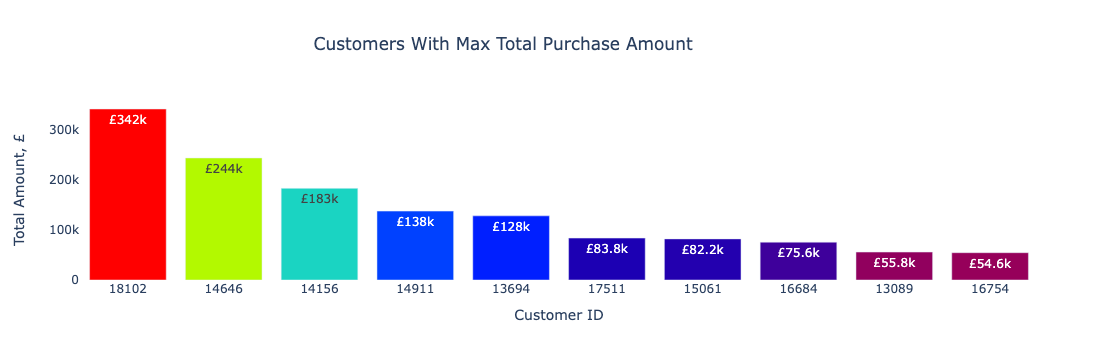

In [60]:
fig = go.Figure(data=[
    go.Bar(name='Customers With Max Total Purchase Amount', 
           x=retail_customers_desc['Customer ID'].astype(str), 
           y=retail_customers_desc['Total'],
           marker_opacity=1,
           hovertext=retail_customers_desc['Country'],
           marker={'color': retail_customers_desc['Total'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='£%{y:.3s}', textposition='inside')

fig.update_layout(title='Customers With Max Total Purchase Amount',
                  title_x=0.45,
                  xaxis_title="Customer ID",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

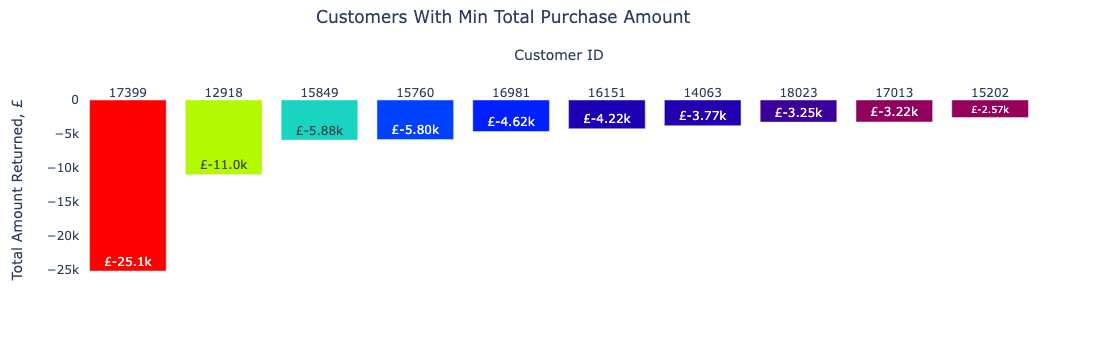

In [61]:
fig = go.Figure(data=[
    go.Bar(name='Customers With Min Total Purchase Amount', 
           x=retail_customers_asc['Customer ID'].astype(str), 
           y=retail_customers_asc['Total'],
           marker_opacity=1,
           hovertext=retail_customers_desc['Country'],
           marker={'color': retail_customers_desc['Total'],
                   'colorscale': 'Rainbow'}
          )
    ])
fig.update_xaxes(side="top")

fig.update_traces(texttemplate='£%{y:.3s}', textposition='inside')

fig.update_layout(title='Customers With Min Total Purchase Amount',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Customer ID",
                  yaxis_title="Total Amount Returned, £",
                  plot_bgcolor='white')
fig.show()

What have we learned from the charts?

Customer with ID 18102 has spent most money in our online store during two years. He comes from United Kingdom, and has paid in total £598k. Another customer from Netherlands comes close to that number - he has spent £523k. In general the top 10 consists of customers from UK, EIRE, Netherlands and Australia - all countries with mature economies.

On the chart showing customers who spent the least, we can see only negative numbers. From our dataset alone, it seems that those are returns. The largest total negative sum is £25k, and the customer with this returned amount comes from UK as well. It is curious that in general customers who have largest negative values here come from the same countries as customers who have paid most. 

## Countries Analysis: Total Purchase Amount

Here, I will find 10 countries, total sum of orders from which was the largest, and also 10 countries, where total purchases were minimal.

In [62]:
retail_countries_purchase = retail.groupby(['Country'], as_index=False)['Total'].agg('sum')
retail_countries_purchase_asc = retail_countries_purchase.sort_values('Total').head(10)
retail_countries_purchase_desc = retail_countries_purchase.sort_values('Total', ascending=False).head(10)

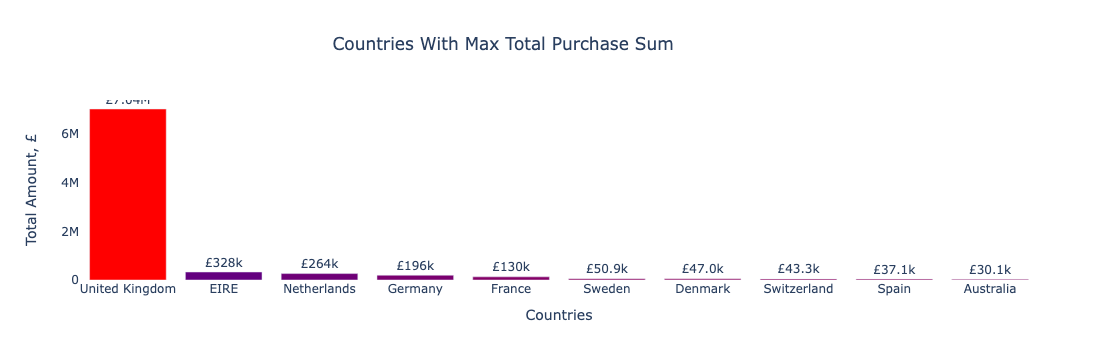

In [63]:
fig = go.Figure(data=[
    go.Bar(name='Countries With Max Total Purchase Amount', 
           x=retail_countries_purchase_desc['Country'].astype(str), 
           y=retail_countries_purchase_desc['Total'],
           marker_opacity=1,
           marker={'color': retail_countries_purchase_desc['Total'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='£%{y:.3s}', textposition='outside')

fig.update_layout(title='Countries With Max Total Purchase Sum',
                  title_x=0.45,
                  xaxis_title="Countries",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

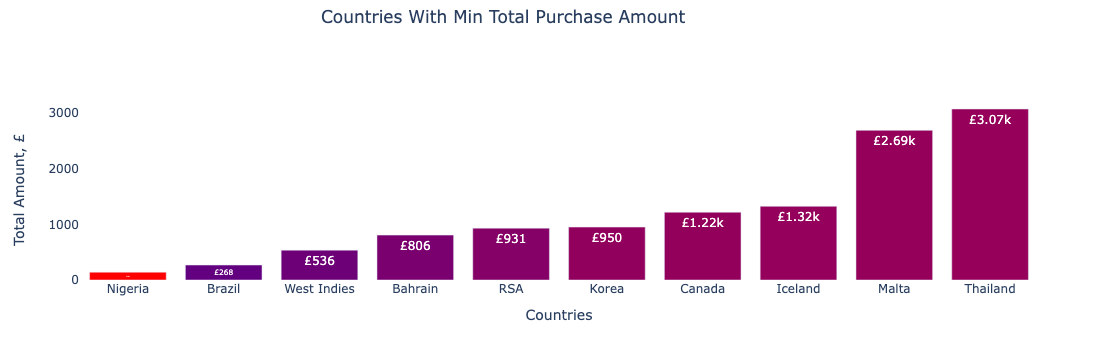

In [64]:
fig = go.Figure(data=[
    go.Bar(name='Countries With Min Total Purchase Amount', 
           x=retail_countries_purchase_asc['Country'].astype(str), 
           y=retail_countries_purchase_asc['Total'],
           marker_opacity=1,
           marker={'color': retail_countries_purchase_desc['Total'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_traces(texttemplate='£%{y:.3s}', textposition='inside')

fig.update_layout(title='Countries With Min Total Purchase Amount',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Countries",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

If we look at the 10 countries, where maximal purchase totals originate from, it is very clear that United Kingdom is a leader with purchase amount of £13.8M. The closest amount to that is £579k - that much was purchased by EIRE customers. It is 23 times less! One other interesting insight is that all countries in the top ten are located in Europe.

The country with the smallest purchase value is Saudi Arabia. Customers from Saudi Arabia have spent only £131 in the online shop in two years! While generally countries with smaller purchased amounts are situated outside of Europe, there is an interesting exception: Czech Republic. If I had more data, I would love to dig deeper into the reasons of this fact!

## Countries Analysis: Unique Customers Number

Next, I'm interested in which 10 countries number of unique customers is largest, and in which it is small.


In [65]:
retail_countries_customers = retail.groupby(['Country'], as_index=False)['Customer ID'].agg({'Customer ID': 'nunique'})
retail_countries_customers.rename(columns={'Customer ID': 'Customer Count'}, inplace=True)
retail_countries_customers_asc = retail_countries_customers.sort_values('Customer Count').head(10)
retail_countries_customers_desc = retail_countries_customers.sort_values('Customer Count', ascending=False).head(10)

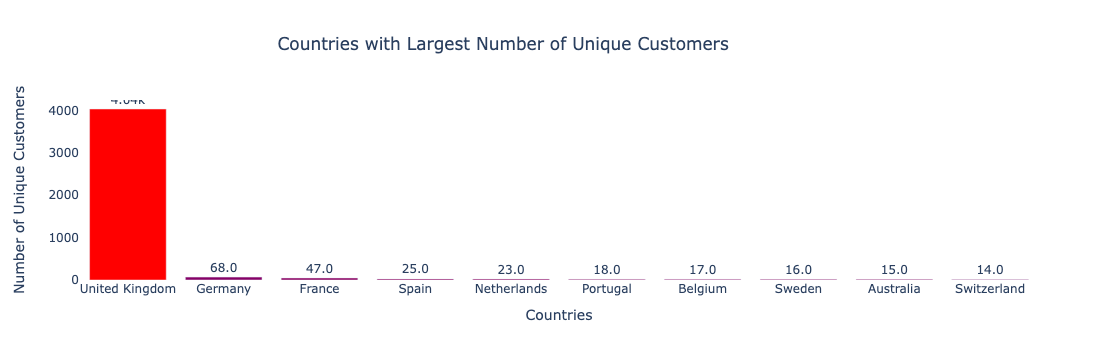

In [66]:
fig = go.Figure(data=[
    go.Bar(name='Countries with Largest Number of Unique Customers', 
           x=retail_countries_customers_desc['Country'].astype(str), 
           y=retail_countries_customers_desc['Customer Count'],
           marker_opacity=1,
           marker={'color': retail_countries_customers_desc['Customer Count'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')

fig.update_layout(title='Countries with Largest Number of Unique Customers',
                  title_x=0.45,
                  xaxis_title="Countries",
                  yaxis_title="Number of Unique Customers",
                  plot_bgcolor='white')
fig.show()

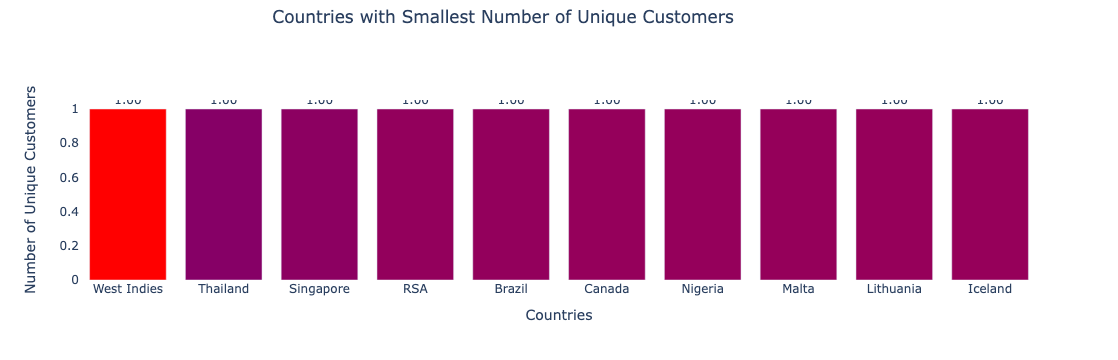

In [67]:
fig = go.Figure(data=[
    go.Bar(name='Countries with Smallest Number of Unique Customers', 
           x=retail_countries_customers_asc['Country'].astype(str), 
           y=retail_countries_customers_asc['Customer Count'],
           marker_opacity=1,
           marker={'color': retail_countries_customers_desc['Customer Count'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')

fig.update_layout(title='Countries with Smallest Number of Unique Customers',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Countries",
                  yaxis_title="Number of Unique Customers",
                  plot_bgcolor='white')
fig.show()

In UK, 5.41k of unique customers have made purchases in two years, while Germany and France follow up with only  107 customers and 95 customers correspondingly. The difference between top position and the followers is indeed huge. Note that we have spotted the same while analysing purchases for each country.  
Also there are many countries with a single unique customer, such as Thailand, Nigeria, Iceland, Saudi Arabia etc. Here, Czech Republic is again an outlier in the list of Asian, South American and African countries, but now we see that also Lithuania and Iceland have only one customer. While Iceland has a relatively small population, it would be interesting to investigate and compare the reasons for Czech Republic and Lithuania. 

## Products Analysis: Quantity 

Next, I will find 10 bestselling products and 10 products which have top number of returns.

I will remove products with description 'Discount' and 'CRUK Commission' to concentrate on the representative data.

In [68]:
retail_products = retail.groupby(['Description'], as_index=False)['Quantity'].agg('sum')
retail_products = retail_products.loc[~retail_products['Description'].isin(['CRUK Commission', 'Discount'])]
retail_products_asc = retail_products.sort_values('Quantity').head(10)
retail_products_asc['Quantity'] = retail_products_asc['Quantity'] * (-1)
retail_products_desc = retail_products.sort_values('Quantity', ascending=False).head(10)

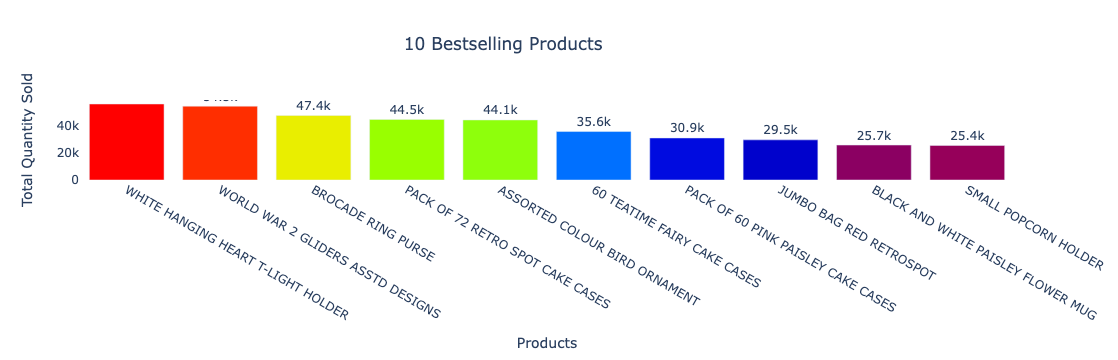

In [69]:
fig = go.Figure(data=[
    go.Bar(name='10 Bestselling Products', 
           x=retail_products_desc['Description'].astype(str), 
           y=retail_products_desc['Quantity'],
           marker_opacity=1,
           marker={'color': retail_products_desc['Quantity'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')
fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title='10 Bestselling Products',
                  title_x=0.45,
                  xaxis_title="Products",
                  yaxis_title="Total Quantity Sold",
                  plot_bgcolor='white')
fig.show()

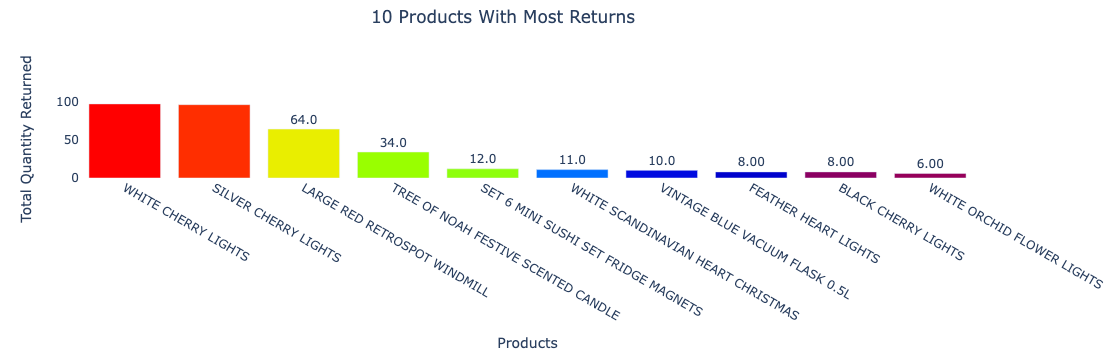

In [70]:
fig = go.Figure(data=[
    go.Bar(name='10 Products With Most Returns', 
           x=retail_products_asc['Description'].astype(str), 
           y=retail_products_asc['Quantity'],
           marker_opacity=1,
           marker={'color': retail_products_desc['Quantity'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')
fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title='10 Products With Most Returns',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Products",
                  yaxis_title="Total Quantity Returned",
                  plot_bgcolor='white')
fig.show()

We can see that **World War II Gliders** are clear bestsellers (the store has sold 107k of them in two years). However quite utilitary things also sell pretty well: mostly in the top ten different holders and cake cases prevail. Also a purse and a jumbo bag can be found there.

The product with most returns is **White Cherry Lights** (105 of them were returned in two years). It is intereting that many decor items and gifts have made it to this list: various candles, flasks, pots, magnets and lights are here. 

## Cohort Analysis

Cohort analysis is generally used to show behavious of users, or in our case, customers, over time. It is an incredibly useful instrument to find some insights about customer experiences, and to understand how to improve that.

I will use cohort analysis to investigate retention rate and average amount of products sold, and choose to use quarters of the year to define my cohorts. 
I will start by slightly transforming my data.

Our dataset covers a timeframe of two years (2010-2011) and additionally December 2009. As December 2009 does not give us a full picture about the quarter, I will remove it.

In order to make calculations easily, each quarter is mapped to an ID. 

I also define my cohort quarter, and calculate cohort index as a difference (number of quarters) between each quarter and the first quarter (having ID 0).

In [71]:
retail = retail[retail['InvoiceDate_DT'].dt.year != 2009]
retail['InvoiceQuarter'] = ('Q' + retail['InvoiceDate_DT'].dt.quarter.astype(str) + 
                            '/' + retail['InvoiceDate_DT'].dt.year.astype(str))
quarters_map = dict(zip(retail['InvoiceQuarter'].unique(), 
                        range(len(retail['InvoiceQuarter'].unique()))))
retail['InvoiceQuarterID'] = retail['InvoiceQuarter'].map(quarters_map)
retail['CohortQuarterID'] = retail.groupby('Customer ID')['InvoiceQuarterID'].transform('min')
retail['CohortQuarter'] = retail['CohortQuarterID'].map(dict(zip(quarters_map.values(), quarters_map.keys())))
retail['CohortIndex'] = retail['InvoiceQuarterID'] - retail['CohortQuarterID']

### Retention Cohort Analysis

First, I will perform retention analysis and investigate the number of active users.
For that, I will group the data, build a pivot table and calculate retention rate in %. Finally, I will plot the triangle chart with Plotly heatmap.

In [72]:
cohort_retention = retail.groupby(['CohortQuarterID', 'CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()
cohort_retention.rename(columns={'Customer ID': 'Customer Count'}, inplace=True)
cohort_retention_count = cohort_retention.pivot_table(index='CohortQuarterID', 
                                                      columns='CohortIndex', 
                                                      values='Customer Count')
cohort_retention_count['CohortQuarter'] = cohort_retention_count.index.map(dict(zip(quarters_map.values(), 
                                                                                    quarters_map.keys())))
cohort_retention_count = cohort_retention_count.set_index('CohortQuarter')
cohort_size = cohort_retention_count.iloc[:, 0]
retention = cohort_retention_count.divide(cohort_size, axis = 0)
retention = (retention*100).round(2)
retention = retention.iloc[::-1]

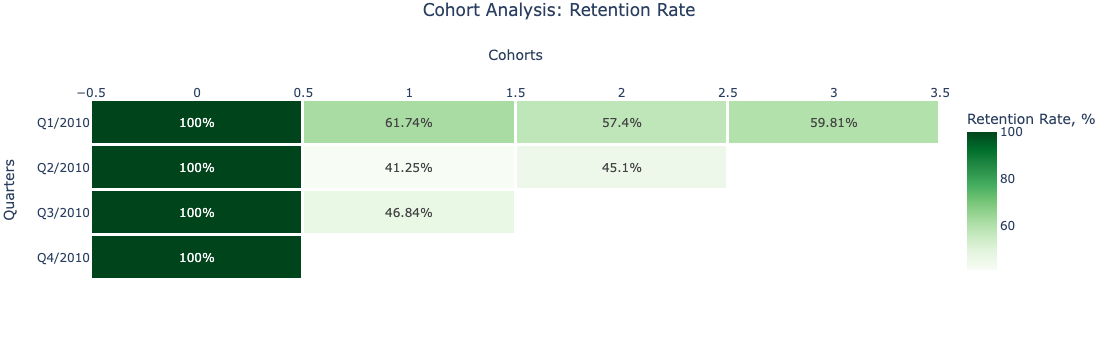

In [73]:
fig = go.Figure(data=go.Heatmap(
                    z=retention,
                    y=retention.index,
                    colorscale='Greens',
                    text=retention,
                    texttemplate = "%{text}%",
                    colorbar_title='Retention Rate, %',
                    xgap=3,
                    ygap=3))

fig.update_xaxes(side="top")

fig.update_layout(title="Cohort Analysis: Retention Rate",
                  xaxis_title="Cohorts",
                  yaxis_title="Quarters",
                  
                  title_x=0.5,
                  title_y=0.99,
                  plot_bgcolor='white')
fig.show()

The results are quite interesting. Have you noticed how retention drops in 2010? An it seems that the store has implemented some measures to improve the situation in 2011, so more customers returned to shop here agein.

### Average Quantity Cohort Analysis

One more dimension I am interested is how many products are sold on average, and how this changes with time.

Here, I will use the same method, but group my data using mean() function.


In [74]:
cohort_quantity = retail.groupby(['CohortQuarterID', 'CohortIndex'])['Quantity'].mean().reset_index()
cohort_quantity.rename(columns={'Quantity': 'Average Quantity'}, inplace=True)
average_quantity  = cohort_quantity.pivot_table(index = 'CohortQuarterID',
                                                columns = 'CohortIndex',
                                                values = 'Average Quantity').round(1)
average_quantity['CohortQuarter'] = average_quantity.index.map(dict(zip(quarters_map.values(), 
                                                                        quarters_map.keys())))
average_quantity = average_quantity.set_index('CohortQuarter')
average_quantity = average_quantity.iloc[::-1]


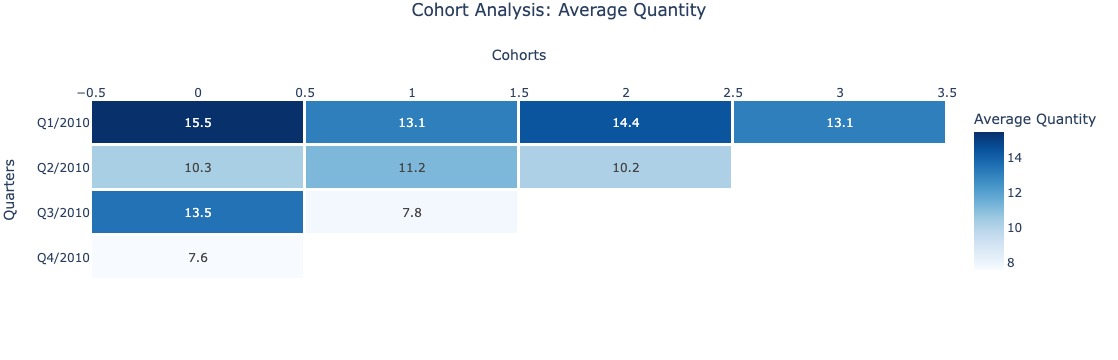

In [75]:
fig = go.Figure(data=go.Heatmap(
                    z=average_quantity,
                    y=average_quantity.index,
                    colorscale='Blues',
                    text=average_quantity,
                    texttemplate = "%{text}",
                    colorbar_title='Average Quantity',
                    xgap=3,
                    ygap=3))

fig.update_xaxes(side="top")

fig.update_layout(title="Cohort Analysis: Average Quantity",
                  xaxis_title="Cohorts",
                  yaxis_title="Quarters",
                  
                  title_x=0.5,
                  title_y=0.99,
                  plot_bgcolor='white')
fig.show()

Here as well, a drop in the average sold quantity of products can be noticed in 2010. In 2011 things started to improve but then dropped back; however it may mean that more expensive products are now sold in smaller amounts.

## Online Sales on Timeline

Finally, I will built two more charts to show how the sales amount was changing with time. I will break down data by quarters and by months.

### Quarterly Sales



In [76]:
retail_quarters_by_sales = retail.groupby(['InvoiceQuarterID'], as_index=False)['Total'].agg('sum')
retail_quarters_by_sales['InvoiceQuarter'] = retail_quarters_by_sales['InvoiceQuarterID'].map(dict(zip(quarters_map.values(), 
                                                                                                               quarters_map.keys())))

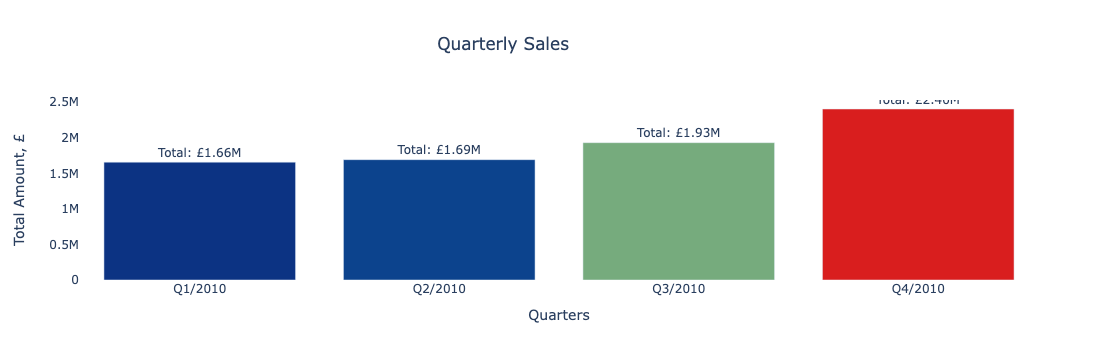

In [77]:
fig = go.Figure(data=[
    go.Bar(name='Quarterly Sales', 
           x=retail_quarters_by_sales['InvoiceQuarter'],
           y=retail_quarters_by_sales['Total'],
           marker_opacity=1,
           text='Total',
           marker={'color': retail_quarters_by_sales['Total'],
                   'colorscale': 'Portland'}
          )
    ])

fig.update_traces(texttemplate='%{text}: £%{y:.3s}', textposition='outside')
fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title="Quarterly Sales",
                  title_x = 0.45,
                  xaxis_title="Quarters",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

We can easily notice the seasonal fluctuations here: people tend to buy a lot before Christmas, and afterwards, a significant drop happens.

### Monthly Sales

In [78]:
retail_monthly = retail.copy()
retail_monthly['InvoiceMonth'] = retail_monthly['InvoiceDate_DT'].dt.to_period('M')
retail_monthly_by_sales = retail_monthly.groupby(['InvoiceMonth'], as_index=False)['Total'].agg('sum')

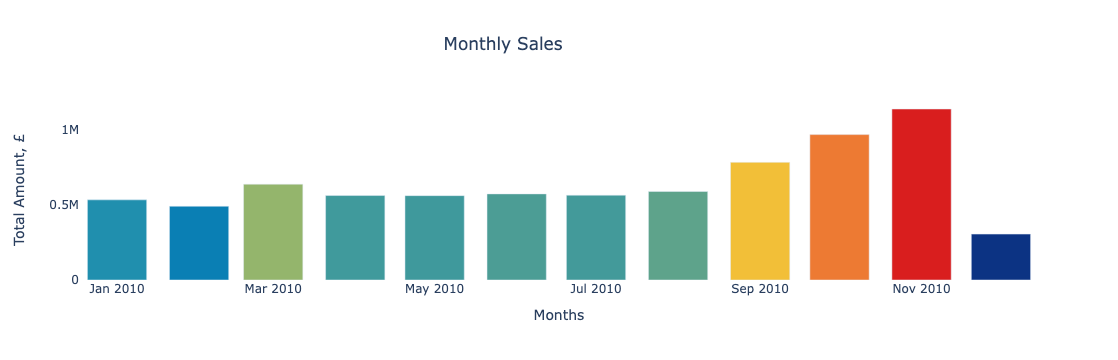

In [79]:
fig = go.Figure(data=[
    go.Bar(name='Monthly Sales', 
           x=retail_monthly_by_sales['InvoiceMonth'].astype(str),
           y=retail_monthly_by_sales['Total'],
           marker_opacity=1,
           marker={'color': retail_monthly_by_sales['Total'],
                   'colorscale': 'Portland'}
          )
    ])

fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title="Monthly Sales",
                  title_x = 0.45,
                  xaxis_title="Months",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

Also with a more precise breakdown you can easily detect the Christams peaks. Note, however, how different December 2011 is from December 2010! December sales have dropped more than twice!

## Conclusion from the EDA

We've learned quite a lot here, and I would like to take a momemnt to summarize the most impactful insights:

- The most expensive product costs **£38970**, while the cheapest one is priced at **£0.001**.
- Customer with ID 18102, who lives in the UK, has purchased different goods for the total value of **£598k** in the last two years, which makes him the most valuable client. Another customer from the UK has returned goods for **£25k** during the same time slot, which is the lowest purchase amount (negative).
- **United Kingdom** is leading in purchases with amount of **£13.8M** and has the largest number of unique customers, while the country with the smallest purchase value is **Saudi Arabia**. Interestingly, customers from Czech Republic tend to buy very little from the store, unlike other European countries. This might be valuable for the marketing team!
- Generally, utilitary items like holders and cases prevail among bestsellers. However the winner is **'World War II Gliders'** - maybe airplane models? Also, different decor items tend to be returned most.
- Retention rate has dropped significantly in **2010**, matching the drop in average sold products, but has raised again in **2011**. It would be indeed great to dig into the reasons, if we had more data to explore.
- Store sales are prominently **seasonal**, however, with **December 2011** being twice less good in terms of income compared to December 2010. This would make also a great starting point for a deeper analysis.


## KMeans Clusterring

In [80]:
df = pd.read_excel('online_retail_II.xlsx')
df['date'] = pd.to_datetime(df['InvoiceDate']).dt.date

#### Doing RFM Analysis

In [81]:
unique_cid = list(df['Customer ID'].unique())

#### Calculating Recency

In [82]:
today = pd.to_datetime(date.today())
recency = []
for i in unique_cid:
    df1 = df[df['Customer ID'] == i]
    if not df1.empty:
        last_purchase_date = df1['date'].iloc[-1]
        last_purchase_date = pd.to_datetime(last_purchase_date)
        diff = today - last_purchase_date
        recency.append(diff.days)
    else:
        recency.append(None) 



#### Calculating Frequency

In [83]:
freq=[]
for i in unique_cid:
    df1=df[df['Customer ID']==i]
    freq.append(len(df1))

#### Calculating Monetory Value

In [84]:
Money=[]
for i in unique_cid:
    df1=df[df['Customer ID']==i]
    df1['Prod']=df1['Quantity'] * df1['Price']
    Money.append(sum(df1['Prod']))
    

In [85]:
dff_new={}
dff_new['Recency']=recency
dff_new['Frequency']=freq
dff_new['Money Spent']=Money
df_new=pd.DataFrame(dff_new)
df_new = df_new.dropna()

In [86]:
scaler = StandardScaler()
df_new.iloc[:,1:4]= scaler.fit_transform(df_new.iloc[:,1:4])

#### Finding the optimal K

In [87]:
silhouetteScoreDict={}
for k in range(2,8):
    kMeansModel = KMeans(n_clusters=k)
    kMeansModel = kMeansModel.fit(df_new)
    clusterIndex = kMeansModel.labels_
    silhouetteScore = silhouette_score(df_new, clusterIndex)
    silhouetteScoreDict[k] = silhouetteScore
sortedScores = sorted(silhouetteScoreDict.items(), key=operator.itemgetter(1), reverse=True)
bestCluster = sortedScores[0][0]

#### Building the Clusteriing model with the best K

In [88]:
kmeans = KMeans(n_clusters=bestCluster, random_state=0)
df_new['Cluster'] = kmeans.fit_predict(df_new)


#### Analyzing and Interpretting the Clusters

In [89]:
print("Centroids of the clusters:")
print(kmeans.cluster_centers_)

cluster_summary = df_new.groupby('Cluster').mean()
print(cluster_summary)

print(df_new['Cluster'].value_counts())


Centroids of the clusters:
[[ 5.11625281e+03 -3.23304262e-01 -1.74355276e-01]
 [ 4.91282745e+03  1.04159563e-01  5.61723785e-02]]
             Recency  Frequency  Money Spent
Cluster                                     
0        5116.252809  -0.323304    -0.174355
1        4912.827451   0.104160     0.056172
Cluster
1    3315
0    1068
Name: count, dtype: int64


#### Plotting the clusters in 2D space


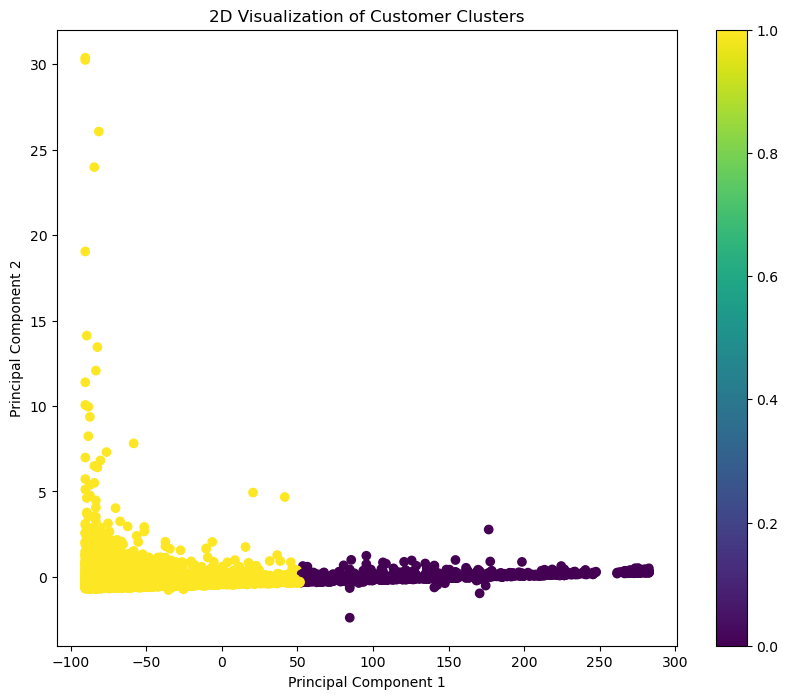

In [90]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_new)
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df_new['Cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Customer Clusters')
plt.colorbar()
plt.show()
